In [1]:
!pip install gsw

     |████████████████████████████████| 2.1 MB 1.7 MB/s eta 0:00:01


In [2]:
#Download the Falkor and RR data
![[ -e falkor_data.tsv ]] || wget http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/Microbial_Mysteries/bottle_data.flat0? -O falkor_data.tsv
![[ -e rr_data.tsv ]] || wget http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/ETNP_ParticleOmics/bottle.flat0?Cruise=RR1804 -O rr_data.tsv

--2021-04-02 11:58:03--  http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/Microbial_Mysteries/bottle_data.flat0?
Resolving dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)... 128.128.181.50
Connecting to dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)|128.128.181.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘falkor_data.tsv’

falkor_data.tsv         [    <=>             ] 226.36K   242KB/s    in 0.9s    

2021-04-02 11:58:04 (242 KB/s) - ‘falkor_data.tsv’ saved [231792]

--2021-04-02 11:58:04--  http://dmoserv3.bco-dmo.org/jg/serv/BCO-DMO/ETNP_ParticleOmics/bottle.flat0?Cruise=RR1804
Resolving dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)... 128.128.181.50
Connecting to dmoserv3.bco-dmo.org (dmoserv3.bco-dmo.org)|128.128.181.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘rr_data.tsv’

rr_data.tsv             [    <=>             ] 255.39K   312KB/s    in 0.8s    

2021-0

In [16]:
import pandas as pd
import gsw
import numpy as np

#"Conservative temperature, absolute salinity, oxygen, phosphate, and spiciness were used for this OMPA study"

def process_falkor():
    df = pd.read_csv("falkor_data.tsv", delim_whitespace=True, header=0,
                     na_values=-999)
    df["lat"] = df["LATITUDE"]
    df["lon"] = df["LONGITUDE"]
    df["pressure"] = df["CTDPRS"]
    df["Depth"] = -gsw.z_from_p(p=df["pressure"], lat=df["lat"])
    df["absolute_salinity"] = gsw.SA_from_SP(
                              SP=df["CTDSAL"],
                              p=df["pressure"],
                              lon=df["lon"],
                              lat=df["lat"])
    df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                          t=df["CTDTMP"],
                                          p=df["pressure"])
    df["oxygen"] = df["CTDOXY"]
    df["phosphate"] = np.nan_to_num(df["PHSPHT"], nan=0.0)
    df["spiciness"] = gsw.spiciness0(SA=df["absolute_salinity"],
                                   CT=df["conservative_temp"])
    df["nitrate"] = np.nan_to_num(df["NOx"] - df["NITRIT_BabLab"], nan=0.0) #q: is NOx better to use?
    df["sigma0"] = gsw.rho(SA=df["absolute_salinity"],
                       CT=df["conservative_temp"], p=0) - 1000
    df["mass"] = 1
    return df

def process_rr():
    df = pd.read_csv("rr_data.tsv", delim_whitespace=True, header=0,
                     na_values="nd")
    df["lat"] = df["Latitude"]
    df["lon"] = df["Longitude"]
    df["pressure"] = gsw.p_from_z(z=-df["Depth"], lat=df["lat"])
    df["absolute_salinity"] = gsw.SA_from_SP(
                                  SP=0.5*(df["Sal0"] + df["Sal1"]),
                                  p=df["pressure"],
                                  lon=df["lon"],
                                  lat=df["lat"])
    df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                          t=0.5*(df["T0"] + df["T1"]),
                                          p=df["pressure"])
    df["oxygen"] = 0.5*(df["Sbeox_0"] + df["Sbeox_1"])
    df["phosphate"] = np.nan_to_num(x=df["PO4"], nan=0.0)
    df["spiciness"] = gsw.spiciness0(SA=df["absolute_salinity"],
                                     CT=df["conservative_temp"])
    df["nitrate"] = np.nan_to_num(x=df["NO3"], nan=0.0)
    #(I am not sure why the Sigma_0 column of the original table gives a different
    # answer - rounding errors?)
    df["sigma0"] = gsw.rho(SA=df["absolute_salinity"],
                         CT=df["conservative_temp"], p=0) - 1000
    df["mass"] = 1
    return df

falkor_df = process_falkor()
rr_df = process_rr()


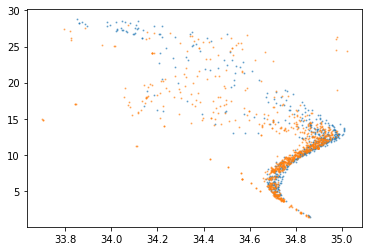

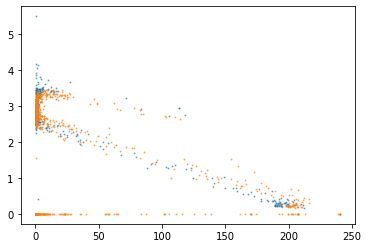

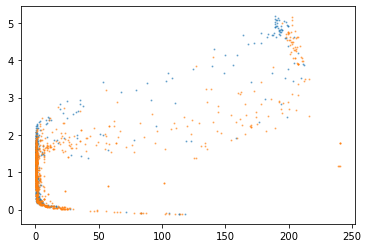

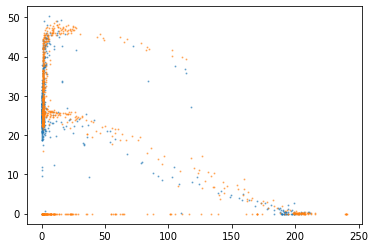

In [7]:
#sanity check by replotting some figures from Fig 3
from matplotlib import pyplot as plt

plt.scatter(falkor_df["absolute_salinity"],
            falkor_df["conservative_temp"], s=1, alpha=0.5)
plt.scatter(rr_df["absolute_salinity"],
            rr_df["conservative_temp"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["phosphate"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["phosphate"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["spiciness"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["spiciness"], s=1, alpha=0.5)
plt.show()

plt.scatter(falkor_df["oxygen"],
            falkor_df["nitrate"], s=1, alpha=0.5)
plt.scatter(rr_df["oxygen"],
            rr_df["nitrate"], s=1, alpha=0.5)
plt.show()

In [35]:
def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name",
                               "conservative_temp", "absolute_salinity",
                               "oxygen", "phosphate", "spiciness"])
    df["mass"] = 1
    return df

#From table 1 in the text
                                   #Temp  Sal    Oxy     Phos     Spic
TSW_FK =         ["TSW_FK",        26.95, 34.06, 192.70, 0.223,  4.970]
ESW_FK =         ["ESW_FK",        23.28, 34.56, 212.00, 0.170,  3.800]
PSUW_proxy_FK =  ["PSUW_proxy_FK", 15.93, 34.13, 188.40, 0.437,  1.790]
CW13_FK =        ["13CW_FK",       12.54, 34.98,   0.59, 2.730,  1.580]
NEPIW_FK =       ["NEPIW_FK",       9.56, 34.80,   0.64, 3.100,  0.894]

TSW_RR =         ["TSW_RR",        26.56, 33.83, 192.70, 0.223,  4.360]
ESW_RR =         ["ESW_RR",        21.26, 34.44, 212.00, 0.170,  3.300]
PSUW_proxy_RR =  ["PSUW_proxy_RR", 16.71, 34.13, 188.40, 0.437,  1.910]
CW13_RR =        ["13CW_RR",       13.08, 34.95,   0.69, 2.730,  1.680]
NEPIW_RR =       ["NEPIW_RR",       9.56, 34.80,   0.90, 3.100,  0.894]

AAIW =           ["AAIW",           6.03, 34.70,   4.80, 3.480,  0.418]
UCDW_proxy =     ["UCDW_proxy",     1.42, 34.87, 118.00, 2.670, -0.110]


surfacewaters_FK_endmemberdf = prepare_endmember_df([
                    TSW_FK, ESW_FK, PSUW_proxy_FK,
                    CW13_FK#, NEPIW_FK, AAIW, UCDW_proxy
])

intermediatewaters_FK_endmemberdf = prepare_endmember_df([
                    #TSW_FK, ESW_FK, PSUW_proxy_FK,
                    CW13_FK, NEPIW_FK, AAIW#, UCDW_proxy
])

intermediatewaters_RR_endmemberdf = prepare_endmember_df([
                    #TSW_RR, ESW_RR, PSUW_proxy_RR,
                    CW13_RR, NEPIW_RR, AAIW#, UCDW_proxy
])

In [31]:
surfacewaters_FK_endmemberdf

,endmember_name,conservative_temp,absolute_salinity,oxygen,phosphate,spiciness,mass
0,TSW_FK,26.95,34.06,192.70,0.223,4.97,1
1,ESW_FK,23.28,34.56,212.00,0.170,3.80,1
2,PSUW_proxy_FK,15.93,34.13,188.40,0.437,1.79,1
3,13CW_FK,12.54,34.98,0.59,2.730,1.58,1


In [15]:
falkor_df

,CRUISEID,EXPOCODE,STNNBR,CASTNO,SAMPNO,DATE,TIME,ISO_DateTime_UTC,LATITUDE,LONGITUDE,...,pressure,Depth,absolute_salinity,conservative_temp,oxygen,phosphate,spiciness,nitrate,sig0,mass
0,FK180624,33FA20180624,1,1,1,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99756,-101.99646,...,1007.273,999.007122,34.734311,4.438064,10.023,3.713901,0.104726,42.624000,27.398862,1
1,FK180624,33FA20180624,1,1,2,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99696,-101.99638,...,761.228,755.425321,34.723428,5.577083,2.048,3.670797,0.241299,39.711000,27.258623,1
2,FK180624,33FA20180624,1,1,3,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99666,-101.99637,...,674.359,669.357886,34.734016,6.169364,1.936,3.439116,0.329904,37.249000,27.192579,1
3,FK180624,33FA20180624,1,1,4,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99634,-101.99632,...,575.667,571.533231,34.739875,6.906517,1.906,3.390625,0.440519,33.486132,27.099100,1
4,FK180624,33FA20180624,1,1,5,30-06-2018,06:30:11,2018-06-30T13:30:11Z,13.99590,-101.99632,...,475.147,471.849141,34.762251,8.057770,1.814,4.155711,0.634736,27.202357,26.951400,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,FK180624,33FA20180624,19,1,20,13-07-2018,23:11:09,2018-07-14T06:11:09Z,17.99955,-119.00078,...,90.737,90.173334,34.141537,16.753791,157.980,0.729715,1.929561,3.426572,24.798823,1
523,FK180624,33FA20180624,19,1,21,13-07-2018,23:11:09,2018-07-14T06:11:09Z,17.99953,-119.00073,...,80.813,80.312916,34.154743,18.910799,198.824,0.421936,2.469533,2.716097,24.285130,1
524,FK180624,33FA20180624,19,1,22,13-07-2018,23:11:09,2018-07-14T06:11:09Z,17.99948,-119.00075,...,49.845,49.540272,34.488058,23.164151,211.656,0.170118,3.863681,0.170000,23.384316,1
525,FK180624,33FA20180624,19,1,23,13-07-2018,23:11:09,2018-07-14T06:11:09Z,17.99944,-119.00076,...,28.982,28.806277,34.515713,24.215060,207.283,0.203693,4.185726,0.430000,23.097577,1


In [38]:
%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

surfacewaters_falkordf = pd.DataFrame(falkor_df[(falkor_df["sigma0"] < 26.0)])
intermediatewaters_falkordf = pd.DataFrame(falkor_df[(falkor_df["sigma0"] >= 26.0)
                                                     & (falkor_df["sigma0"] <= 27.0)])
intermediatewaters_rrdf = pd.DataFrame(rr_df[(rr_df["sigma0"] >= 26.0)
                                             & (rr_df["sigma0"] <= 27.0)])

conversionratios_orig = {
    "oxygen": [-1],
    "phosphate": [1.0/170], #170 is the default redfield ratio in matlab OMPA, I also recall seeing it somewhere
}
orig_weighting = (
 [("conservative_temp",24.0),
  ("absolute_salinity",24.0),
  ("spiciness", 7.0),
  ("mass",24.0)],
 [("oxygen",7.0), ("phosphate",2.0)])

surfacewaters_ompa_soln = pyompa.OMPAProblem(
      obs_df = surfacewaters_falkordf,
      paramsandweighting_conserved=orig_weighting[0],
      paramsandweighting_converted=orig_weighting[1],
      conversionratios=conversionratios_orig,
      smoothness_lambda=None,
      endmembername_to_usagepenaltyfunc={},
      sumtooneconstraint=False).solve(
          surfacewaters_FK_endmemberdf,
          endmember_name_column="endmember_name")

FK_intermediatewaters_ompa_soln = pyompa.OMPAProblem(
      obs_df = intermediatewaters_falkordf,
      paramsandweighting_conserved=orig_weighting[0],
      paramsandweighting_converted=orig_weighting[1],
      conversionratios=conversionratios_orig,
      smoothness_lambda=None,
      endmembername_to_usagepenaltyfunc={},
      sumtooneconstraint=False).solve(
          intermediatewaters_FK_endmemberdf,
          endmember_name_column="endmember_name")

RR_intermediatewaters_ompa_soln = pyompa.OMPAProblem(
      obs_df = intermediatewaters_rrdf,
      paramsandweighting_conserved=orig_weighting[0],
      paramsandweighting_converted=orig_weighting[1],
      conversionratios=conversionratios_orig,
      smoothness_lambda=None,
      endmembername_to_usagepenaltyfunc={},
      sumtooneconstraint=False).solve(
          intermediatewaters_RR_endmemberdf,
          endmember_name_column="endmember_name")

params to use: ['conservative_temp', 'absolute_salinity', 'spiciness', 'mass'] ['oxygen', 'phosphate']
param weighting: [24. 24.  7. 24.  7.  2.]
Conversion ratios:
[[-1.          0.00588235]]
status: optimal
optimal value 12751.982862234485
Original weighted sum squares: 12751.98286240371
Post fix weighted sum squared: 12751.982862485493
status: optimal
optimal value 266383.3929590682
Original weighted sum squares: 266383.39295964
Post fix weighted sum squared: 266383.39295972604
status: optimal
optimal value 11983.076924385869
Original weighted sum squares: 11983.076924446792
Post fix weighted sum squared: 11983.076924462774
objective: 11983.076924462774
params to use: ['conservative_temp', 'absolute_salinity', 'spiciness', 'mass'] ['oxygen', 'phosphate']
param weighting: [24. 24.  7. 24.  7.  2.]
Conversion ratios:
[[-1.          0.00588235]]
status: optimal
optimal value 28205.23536100043
Original weighted sum squares: 28205.235361001818
Post fix weighted sum squared: 28205.2353610

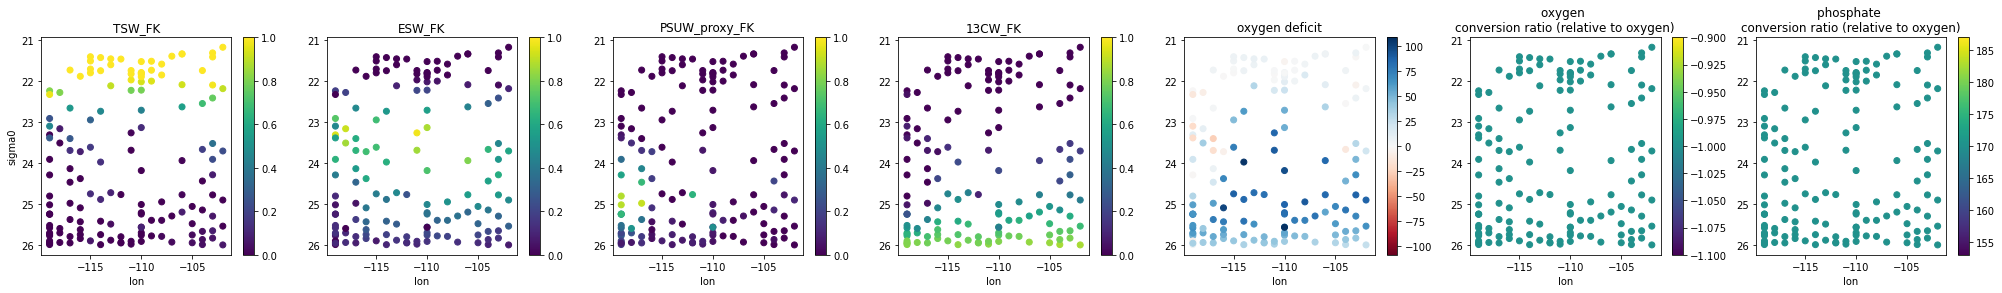

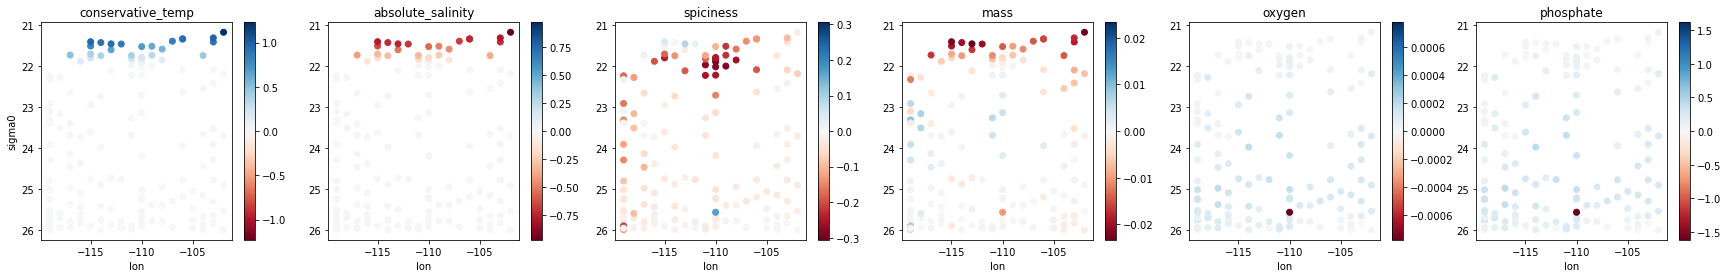

In [44]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

plot_ompasoln_endmember_fractions(ompa_soln=surfacewaters_ompa_soln,
                                  xaxis_colname="lon",
                                  yaxis_colname="sigma0")
plot_ompasoln_residuals(ompa_soln=surfacewaters_ompa_soln,
                        xaxis_colname="lon",
                        yaxis_colname="sigma0")

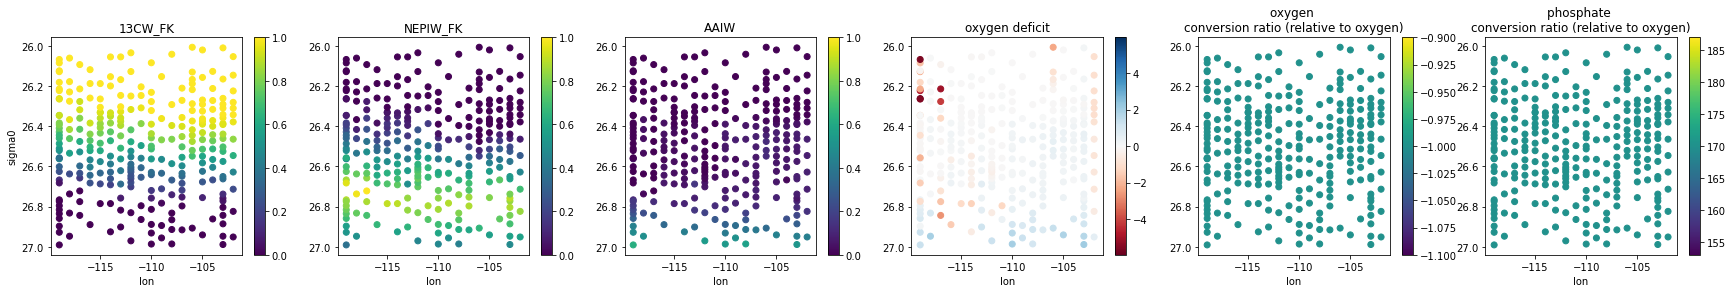

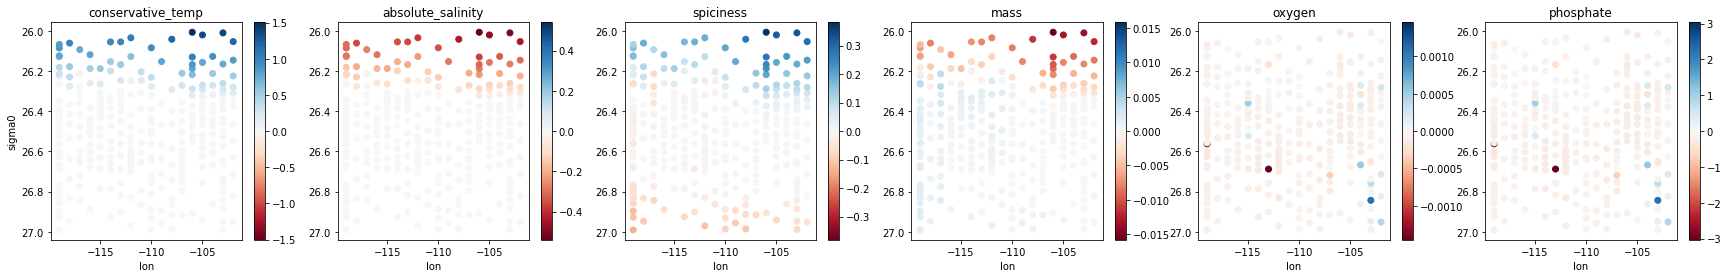

In [42]:
plot_ompasoln_endmember_fractions(ompa_soln=FK_intermediatewaters_ompa_soln,
                                  xaxis_colname="lon",
                                  yaxis_colname="sigma0")
plot_ompasoln_residuals(ompa_soln=FK_intermediatewaters_ompa_soln,
                        xaxis_colname="lon",
                        yaxis_colname="sigma0")

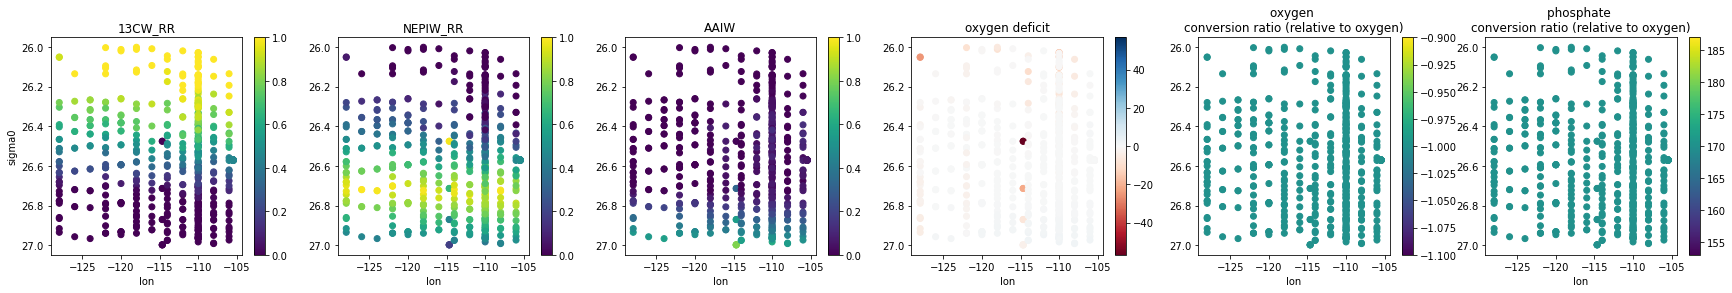

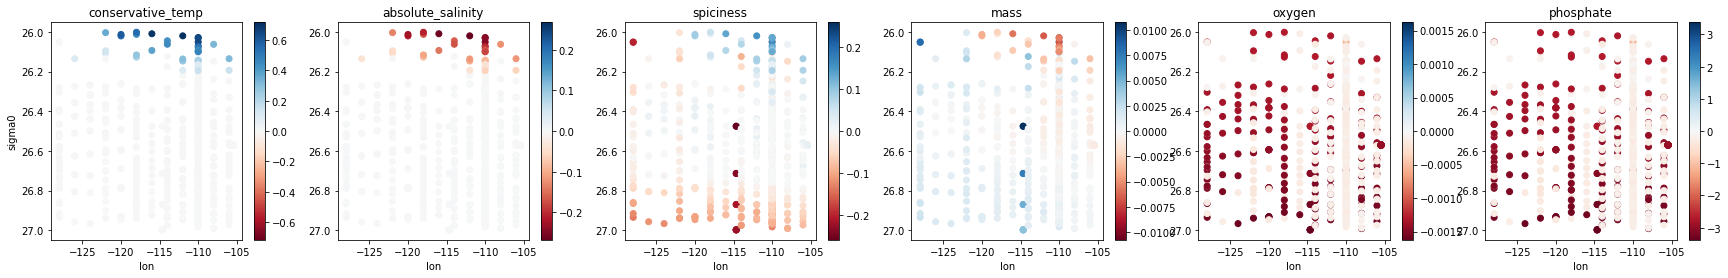

In [43]:
#NOTE: I think the nonneg least squares matlab implementation may constrain the
# remineralization parameter to also be only positive? Would explain why
# evans et al has a v high residual and high AAIW for top left point?
plot_ompasoln_endmember_fractions(ompa_soln=RR_intermediatewaters_ompa_soln,
                                  xaxis_colname="lon",
                                  yaxis_colname="sigma0")
plot_ompasoln_residuals(ompa_soln=RR_intermediatewaters_ompa_soln,
                        xaxis_colname="lon",
                        yaxis_colname="sigma0")